<a href="https://colab.research.google.com/github/43624/demopygit/blob/main/Detection_of_Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


for fn in uploaded.keys():
  print('user uploaded file "{name} with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/&& chmod 600 ~/.kaggle/kaggle.json

KeyboardInterrupt: 

In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 33% 5.00M/15.1M [00:00<00:00, 41.6MB/s]
100% 15.1M/15.1M [00:00<00:00, 91.9MB/s]


Import Pakages for this project

In [3]:
import tensorflow as tensorflow
import os, glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import sys


<ipython-input-3-42a16aadc3de>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


Reading Images

In [4]:
tumor = []
healthy = []
path = './drive/MyDrive/Brain_MRI_Tumor_Detection/data/yes/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)
path = './drive/MyDrive/Brain_MRI_Tumor_Detection/data/no/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [5]:
len(tumor)

86

In [6]:
for img in tumor:
  print(img.shape)


(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

In [7]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [8]:
healthy.shape

(85, 128, 128, 3)

Visualizing Images

In [9]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('tumror')
        plt.imshow(tumor_imgs[i])

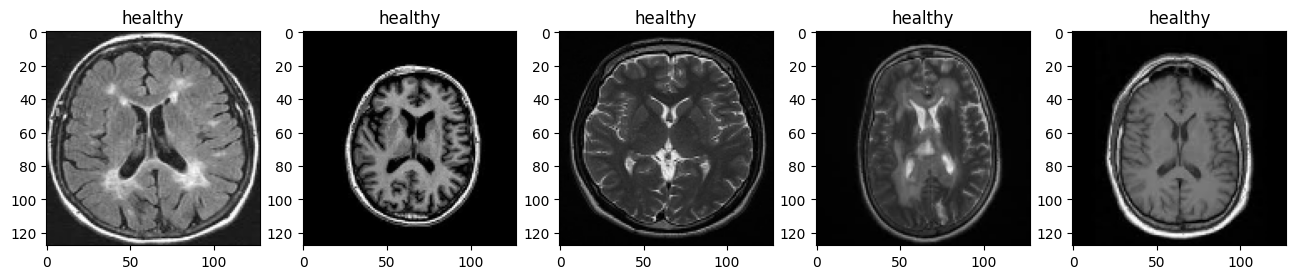

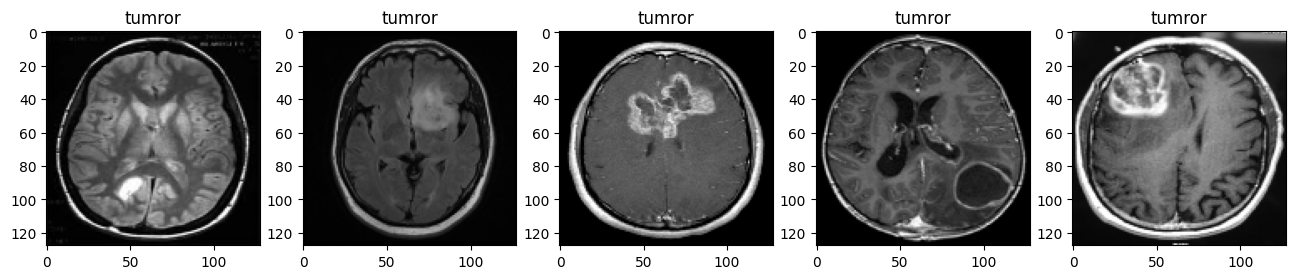

In [10]:
plot_random(healthy, tumor)

**Create Torch Dataset**

Abstract Dataset

In [11]:
class Dataset(object):
    """an abstract class representing a Dataset.

    All other Datasets should subclass it. All subclass should override
    ''--len--'', that provides the size of the Dataset and ''--getitem--'',
    supporting integer indexing in range from 0 to len(self) exclusive"""

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

Custom Dataset

In [12]:
class MRI(Dataset):
    def __init__(self):
        tumor = []
        healthy = []
        path = './drive/MyDrive/Brain_MRI_Tumor_Detection/data/yes/*.jpg'
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[1],img.shape[0]))
            tumor.append(img)
        path = './drive/MyDrive/Brain_MRI_Tumor_Detection/data/no/*.jpg'
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[1],img.shape[0]))
            healthy.append(img)

        # our imagesgfv.=-d
        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)

        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)


        self. images= np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        sample = {'image': self.images[index], 'label': self.labels[index]}
        return sample

    def normalize(self):
        self.images = self.images/255.0


In [13]:
mri = MRI()

In [14]:
mri.normalize()

In [15]:
img = mri[5]['image']

In [16]:
img.shape

(3, 128, 128)

In [17]:
np.max(img)

0.9764706

**Creating DataLoader**

The world without Dataloader

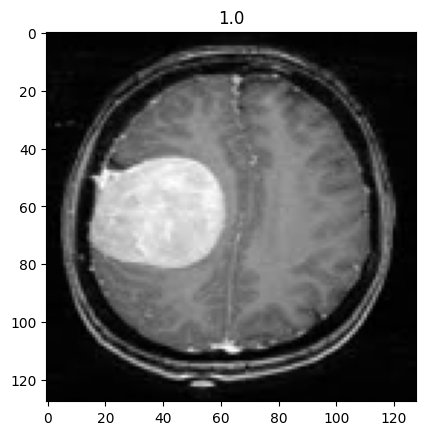

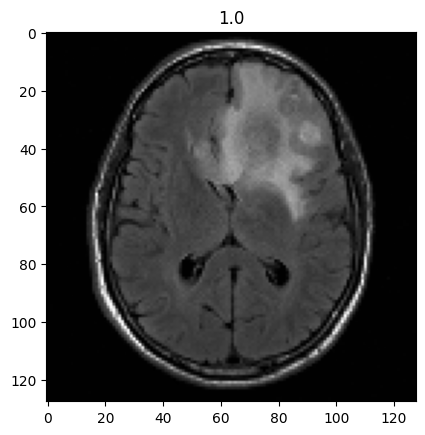

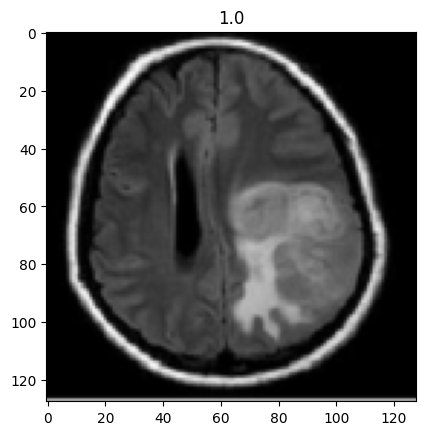

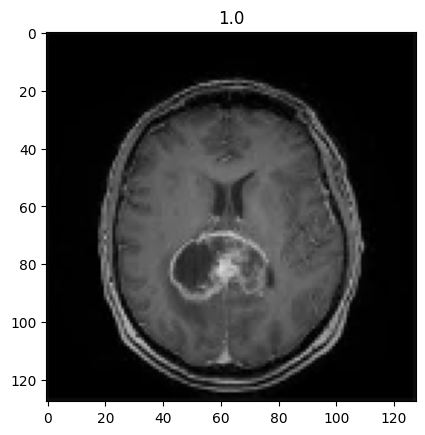

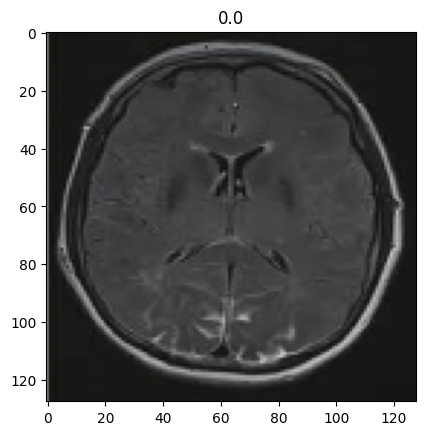

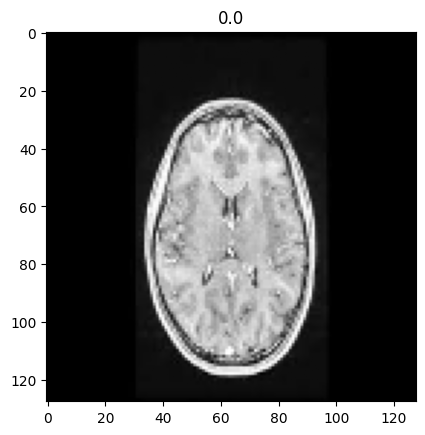

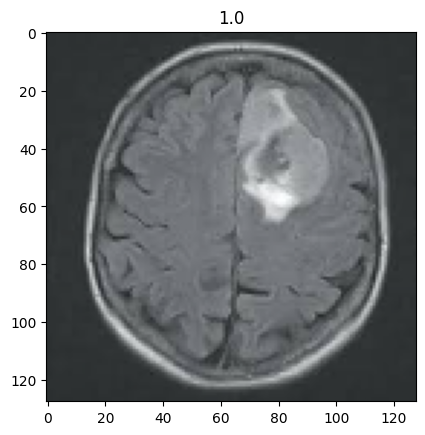

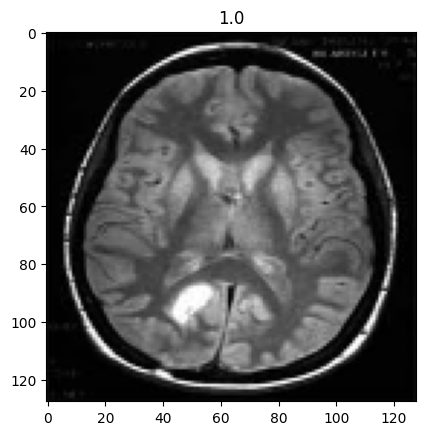

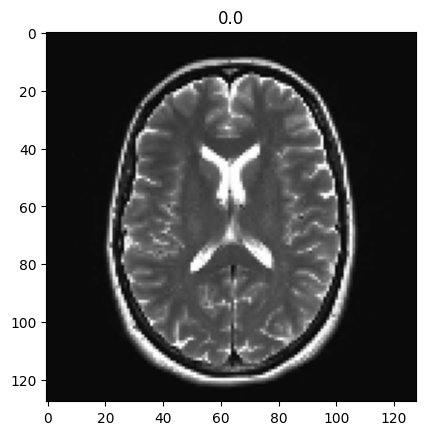

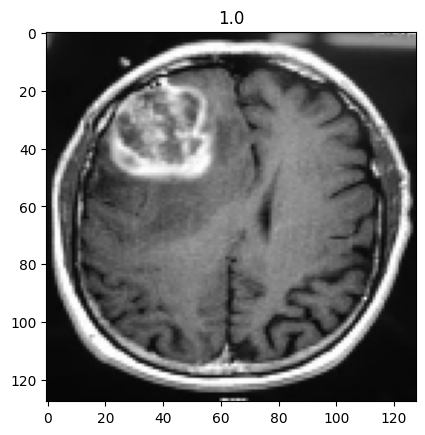

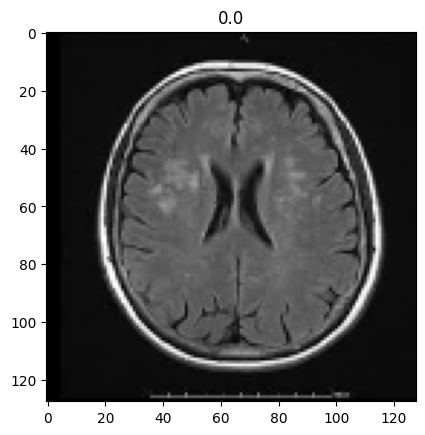

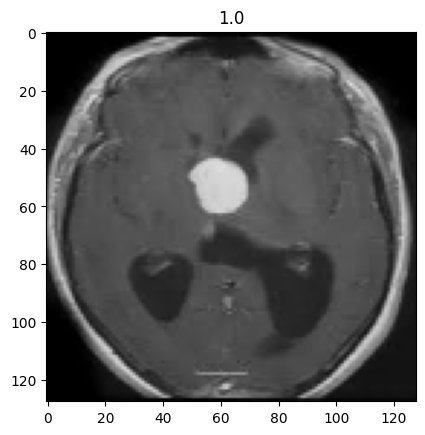

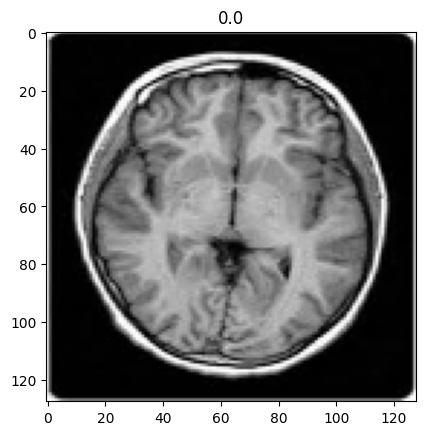

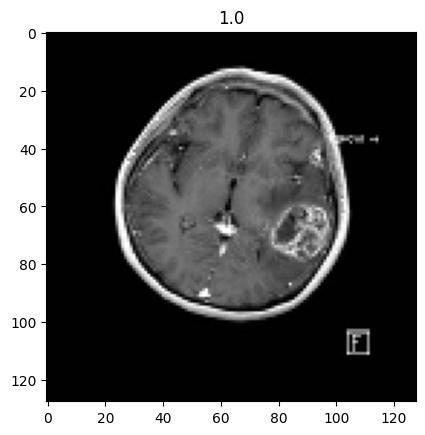

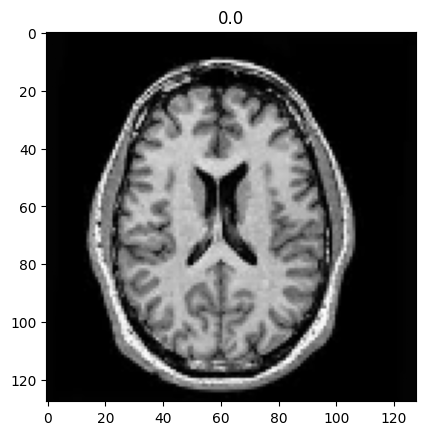

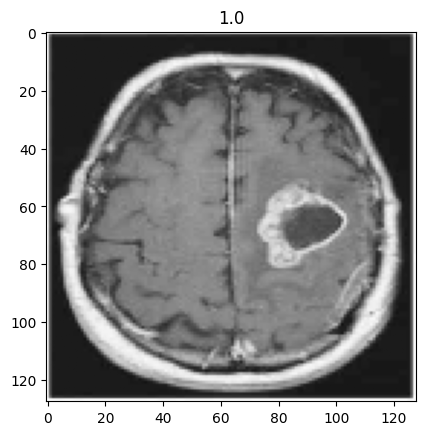

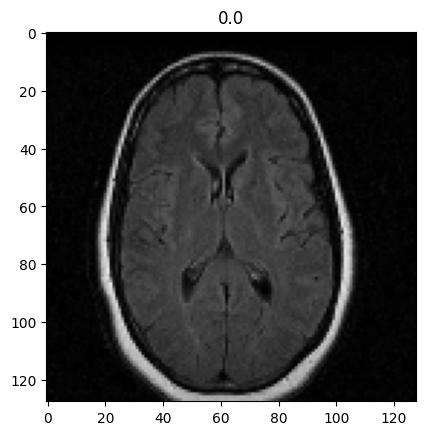

In [ ]:
index = list(range(len(mri)))
random.shuffle(index)
for idx in index:
    sample = mri[idx]
    img = sample['image']
    label = sample['label']
    img = img.reshape(img.shape[2], img.shape[1], img.shape[0])
    plt.title(label)
    plt.imshow(img)
    plt.show()


The World with Dataloaders

In [19]:
dataloader = DataLoader(mri, batch_size=10, shuffle=True)

In [20]:
for sample in dataloader:
    img= sample['image'].squeeze()
    print(img.shape)
    sys.exit()
    #   img = img.reshape(img.shape[0], img.shape[1], img.shape[2])
    #  plt.imshow(img)
    # plt.show()

torch.Size([10, 3, 128, 128])


SystemExit: 

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Create a model

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))

    def forward(self,x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x



The Logic behind the numbers
Here is the grand formul:

Nout=ceil[(Nin+ 2p-f)/s+1]

Look in to the parameters of the model

In [22]:
model = CNN()

In [23]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [24]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
)

torch.tensor vs. torch cuda.tensor

In [25]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.7200, 0.7216, 0.0137, 0.7412, 0.3128, 0.2639, 0.1343, 0.2206, 0.2784,
        0.9853], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.7200, 0.7216, 0.0137, 0.7412, 0.3128, 0.2639, 0.1343, 0.2206, 0.2784,
        0.9853], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([5.1837e-01, 5.2077e-01, 1.8768e-04, 5.4942e-01, 9.7847e-02, 6.9669e-02,
        1.8037e-02, 4.8651e-02, 7.7510e-02, 9.7076e-01], device='cuda:0')


Evaluate a New-Born Neural Network

In [26]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda:0')
model = CNN().to(device)

In [27]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [28]:
model.eval()
outputs = []
y_true = []

with torch.no_grad():

  for D in dataloader:
    image = D['image'].to(device)
    label = D['label'].to(device)

    y_hat = model(image)

    outputs.append(y_hat.cpu().detach().numpy())
    y_true.append(label.cpu().detach().numpy())

In [29]:
outputs = np.concatenate(outputs, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()

In [30]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
  x = np.array(list(scores))
  x[x >= threshold] = maximum
  x[x < threshold] = minimum
  return x

In [31]:
accuracy_score(y_true, threshold(outputs))

0.5029239766081871

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

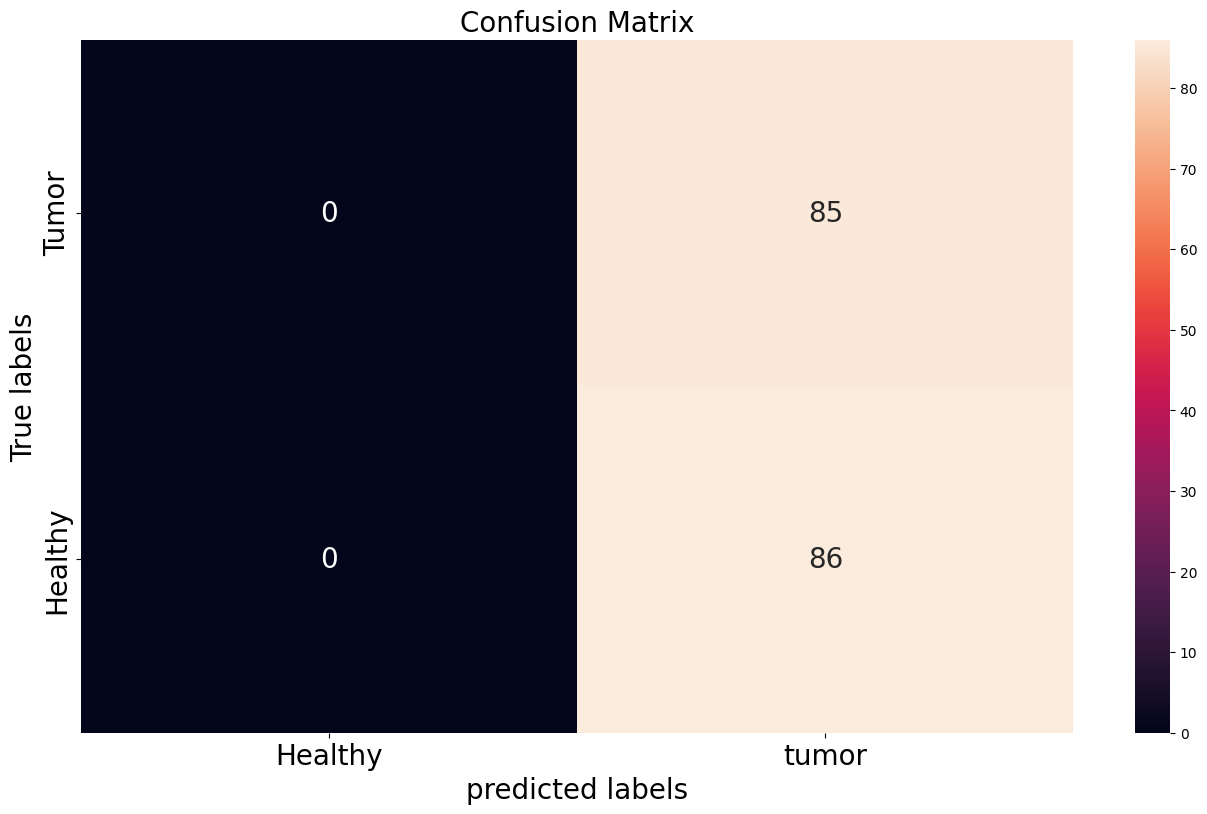

In [32]:
# a  better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy', 'tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor', 'Healthy'], fontsize=20)

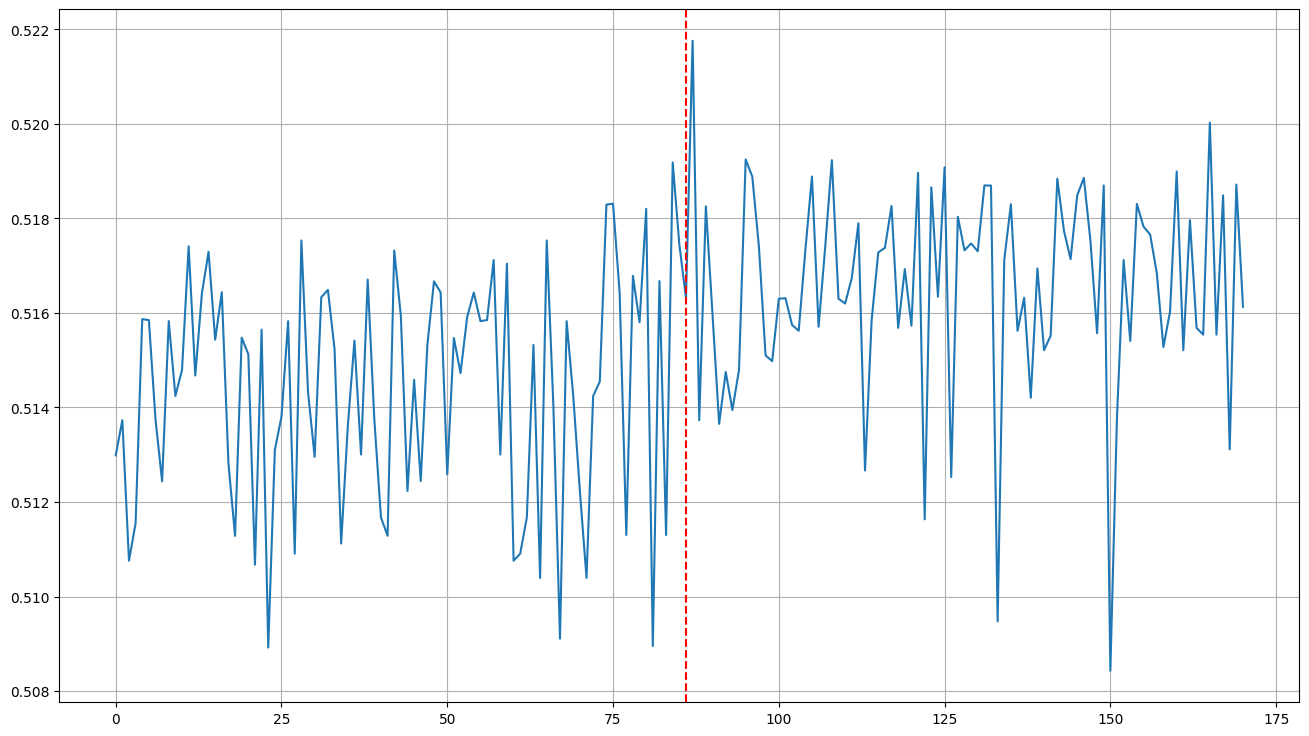

In [33]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

Train a Dumb Model

In [35]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()


CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [36]:
for epoch in range(1,EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(data)

        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))


train Epoch: 10	Loss: 0.674155
train Epoch: 20	Loss: 0.610544
train Epoch: 30	Loss: 0.603365
train Epoch: 40	Loss: 0.544414
train Epoch: 50	Loss: 0.554535
train Epoch: 60	Loss: 0.554120
train Epoch: 70	Loss: 0.532666
train Epoch: 80	Loss: 0.503609
train Epoch: 90	Loss: 0.484234
train Epoch: 100	Loss: 0.445272
train Epoch: 110	Loss: 0.429626
train Epoch: 120	Loss: 0.411419
train Epoch: 130	Loss: 0.371632
train Epoch: 140	Loss: 0.383811
train Epoch: 150	Loss: 0.325229
train Epoch: 160	Loss: 0.309458
train Epoch: 170	Loss: 0.296429
train Epoch: 180	Loss: 0.297103
train Epoch: 190	Loss: 0.220381
train Epoch: 200	Loss: 0.213555
train Epoch: 210	Loss: 0.184399
train Epoch: 220	Loss: 0.164754
train Epoch: 230	Loss: 0.134896
train Epoch: 240	Loss: 0.121567
train Epoch: 250	Loss: 0.098471
train Epoch: 260	Loss: 0.090852
train Epoch: 270	Loss: 0.060501
train Epoch: 280	Loss: 0.050768
train Epoch: 290	Loss: 0.040705
train Epoch: 300	Loss: 0.034733
train Epoch: 310	Loss: 0.025664
train Epoch: 320	

Evaluate a Smart model

In [37]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs = []
y_true = []

with torch.no_grad():

  for D in dataloader:
    image = D['image'].to(device)
    label = D['label'].to(device)

    y_hat = model(image)

    outputs.append(y_hat.cpu().detach().numpy())
    y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate(outputs, axis=0).squeeze()
y_true = np.concatenate(y_true, axis=0).squeeze()

In [38]:
accuracy_score(y_true, threshold(outputs))

1.0

In [39]:
# a  better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy', 'tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor', 'Healthy'], fontsize=20)

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

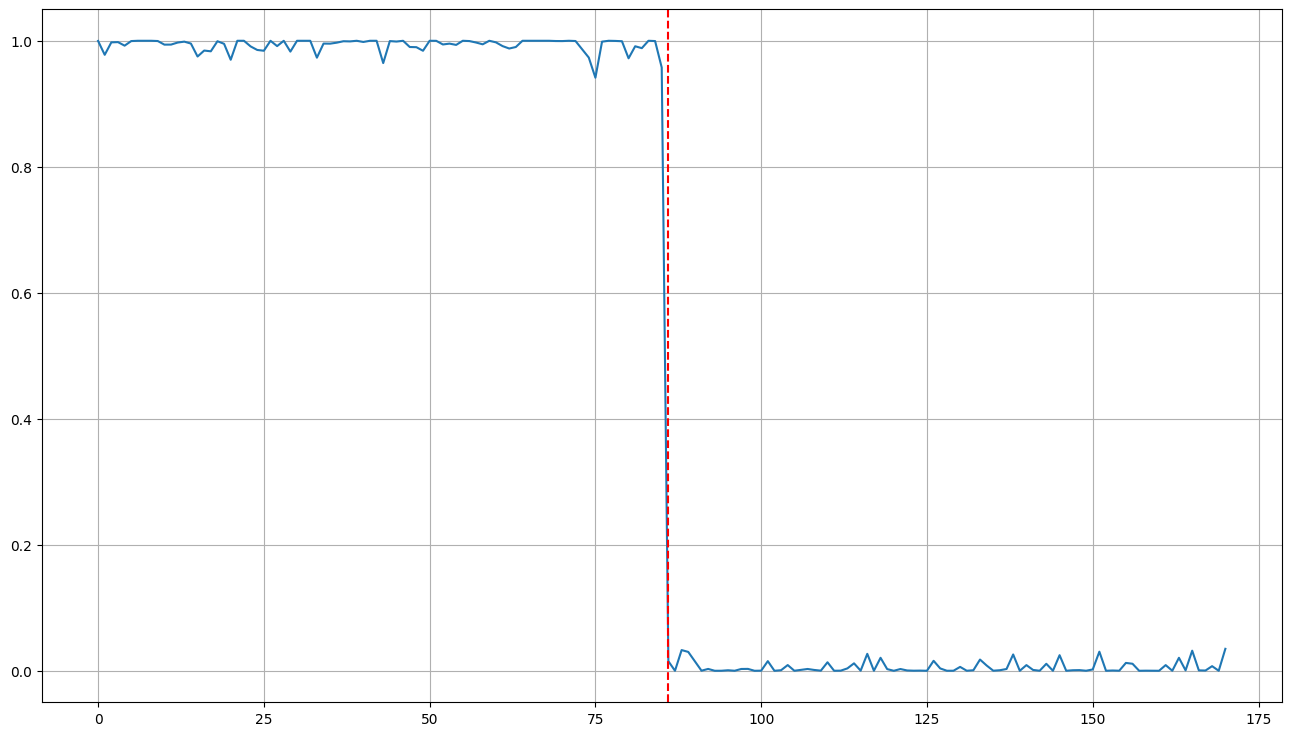

In [40]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

Visualising the Feature Maps of the Convolutional Filters

In [41]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [42]:
no_of_layers = 0
conv_layers = []

In [43]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [44]:
for child in model.children():
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [45]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

In [46]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [47]:
img = torch.from_numpy(img).to(device)

In [48]:
img.shape

torch.Size([3, 128, 128])

In [49]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [50]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

In [51]:
len(outputs)

2

In [52]:
outputs[0].shape

torch.Size([1, 6, 124, 124])

layer  1


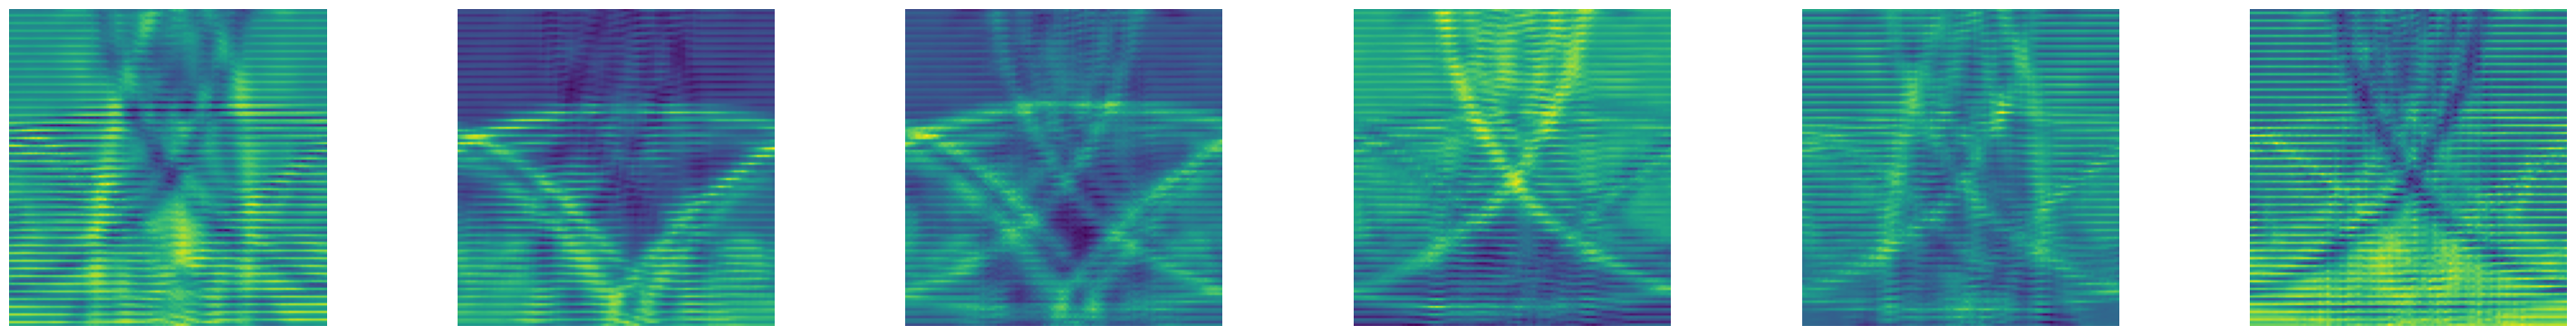

layer  2


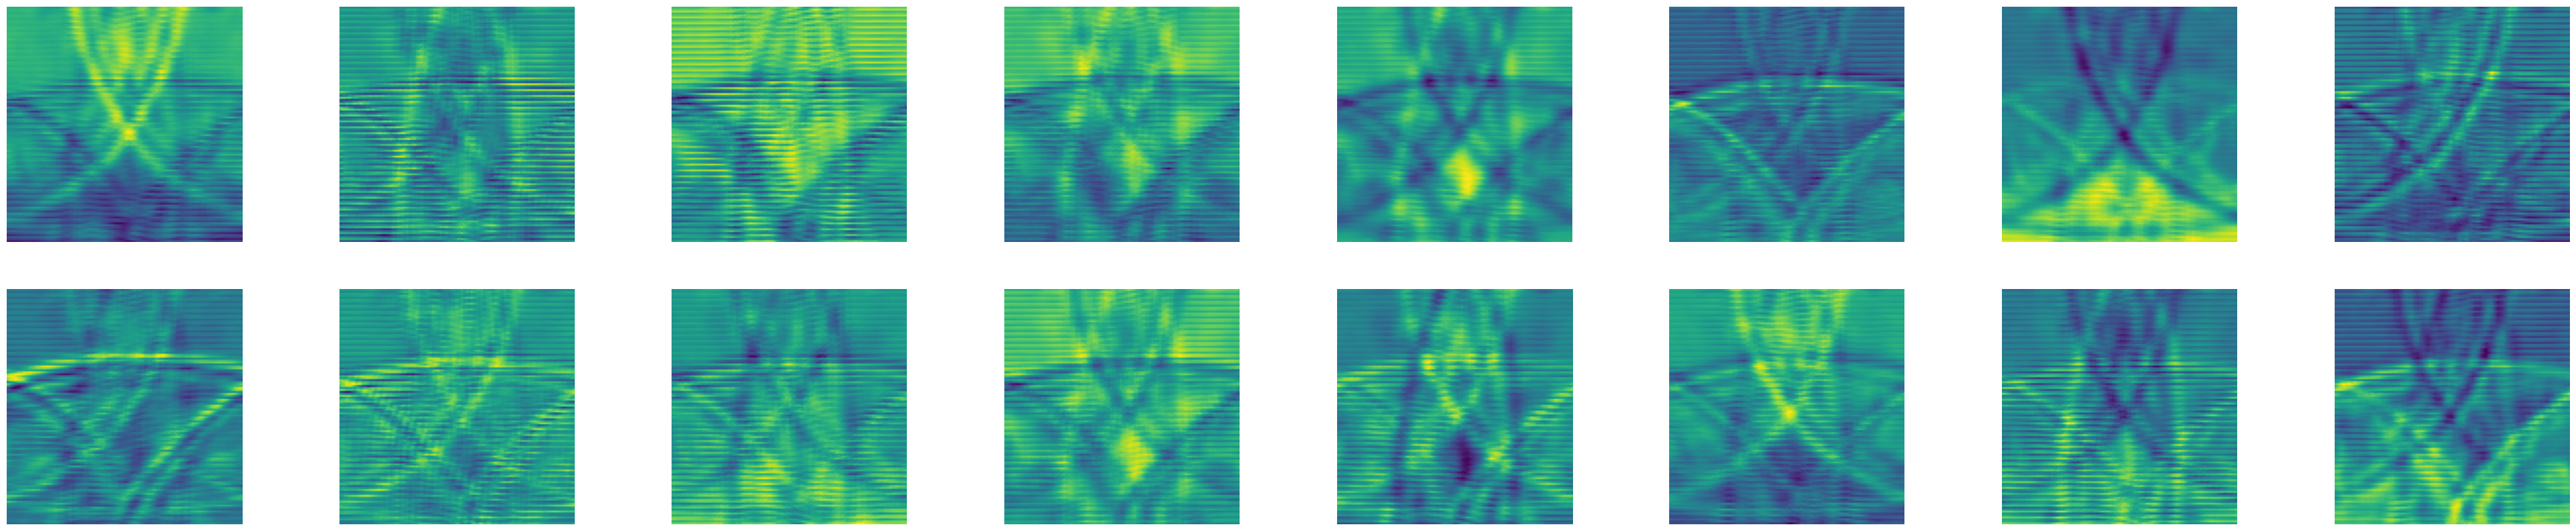

In [53]:
for num_layer in range(len(outputs)):
  plt.figure(figsize=(50, 10))
  layer_viz = outputs[num_layer].squeeze()
  print("layer ",num_layer+1)
  for i, f in enumerate(layer_viz):
    plt.subplot(2,8, i+1)
    plt.imshow(f.detach().cpu().numpy())
    plt.axis('off')
  plt.show()
  plt.close()

Are we over-fitting?

Preparing a validation set: We need to change the MRI dataset slightly

In [54]:
from sklearn.model_selection import train_test_split

In [66]:
class MRI(Dataset):
    def __init__(self):

      # variables to hold the training data and validation data
        self.x_train, self.y_train, self.x_val, self.y_val = None, None, None, None

        # A variable to determine if we are interested in retrievingthe training on the validation data
        self.mode = 'train'
        tumor = []
        healthy = []
        path = './drive/MyDrive/Brain_MRI_Tumor_Detection/data/yes/*.jpg'
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[1],img.shape[0]))
            tumor.append(img)
        path = './drive/MyDrive/Brain_MRI_Tumor_Detection/data/no/*.jpg'
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[1],img.shape[0]))
            healthy.append(img)

        # our imagesgfv.=-d
        tumor = np.array(tumor, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)

        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # concatenate
        self. images= np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

        # Define a function that would seperate the data into training and validation sets
    def train_val_split(self):
      self.x_train, self.x_val, self.y_train, self.y_val = \
      train_test_split(self.images, self.labels, test_size=0.2, random_state=42)
    def __len__(self):
      # use self.mode to determine whether train or val data is of interest
        if self.mode == 'train':
            return self.x_train.shape[0]
        elif self.mode == 'val':
            return self.x_val.shape[0]

    def __getitem__(self, index):
        # use self.mode to determine whether train or val data is of interest
        if self.mode == 'train':
            sample = {'image': self.x_train[index], 'label': self.y_train[index]}
        elif self.mode == 'val':
            sample = {'image': self.x_val[index], 'label': self.y_val[index]}

        return sample

    def normalize(self):
        self.images = self.images/255.0


Are we overfitting?

In [67]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [68]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [69]:
device = torch.device('cuda:0')
model = CNN().to(device)

In [70]:
eta = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [71]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [80]:
for epoch in range(1,600):
    train_losses = []
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    epoch_train_loss.append(np.mean(train_losses))

    # validate for the current epoch
    val_losses = []
    model.eval()
    mri_dataset.mode = 'val'
    with torch.no_grad():
        for D in val_dataloader:
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())

    epoch_val_loss.append(np.mean(val_losses))

    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))




Train Epoch: 10	Train Loss: 0.000084	Val Loss: 1.069932
Train Epoch: 20	Train Loss: 0.000083	Val Loss: 1.071662
Train Epoch: 30	Train Loss: 0.000086	Val Loss: 2.386760
Train Epoch: 40	Train Loss: 0.000102	Val Loss: 2.388243
Train Epoch: 50	Train Loss: 0.000099	Val Loss: 2.389588
Train Epoch: 60	Train Loss: 0.000070	Val Loss: 2.391433
Train Epoch: 70	Train Loss: 0.000067	Val Loss: 2.389871
Train Epoch: 80	Train Loss: 0.000070	Val Loss: 2.392539
Train Epoch: 90	Train Loss: 0.000067	Val Loss: 2.396794
Train Epoch: 100	Train Loss: 0.000070	Val Loss: 2.397220
Train Epoch: 110	Train Loss: 0.000066	Val Loss: 2.397299
Train Epoch: 120	Train Loss: 0.000057	Val Loss: 2.397483
Train Epoch: 130	Train Loss: 0.000064	Val Loss: 2.399229
Train Epoch: 140	Train Loss: 0.000058	Val Loss: 2.399579
Train Epoch: 150	Train Loss: 0.000052	Val Loss: 2.402205
Train Epoch: 160	Train Loss: 0.000055	Val Loss: 2.404273
Train Epoch: 170	Train Loss: 0.000076	Val Loss: 2.405324
Train Epoch: 180	Train Loss: 0.000055	Va

Text(0, 0.5, 'Loss')

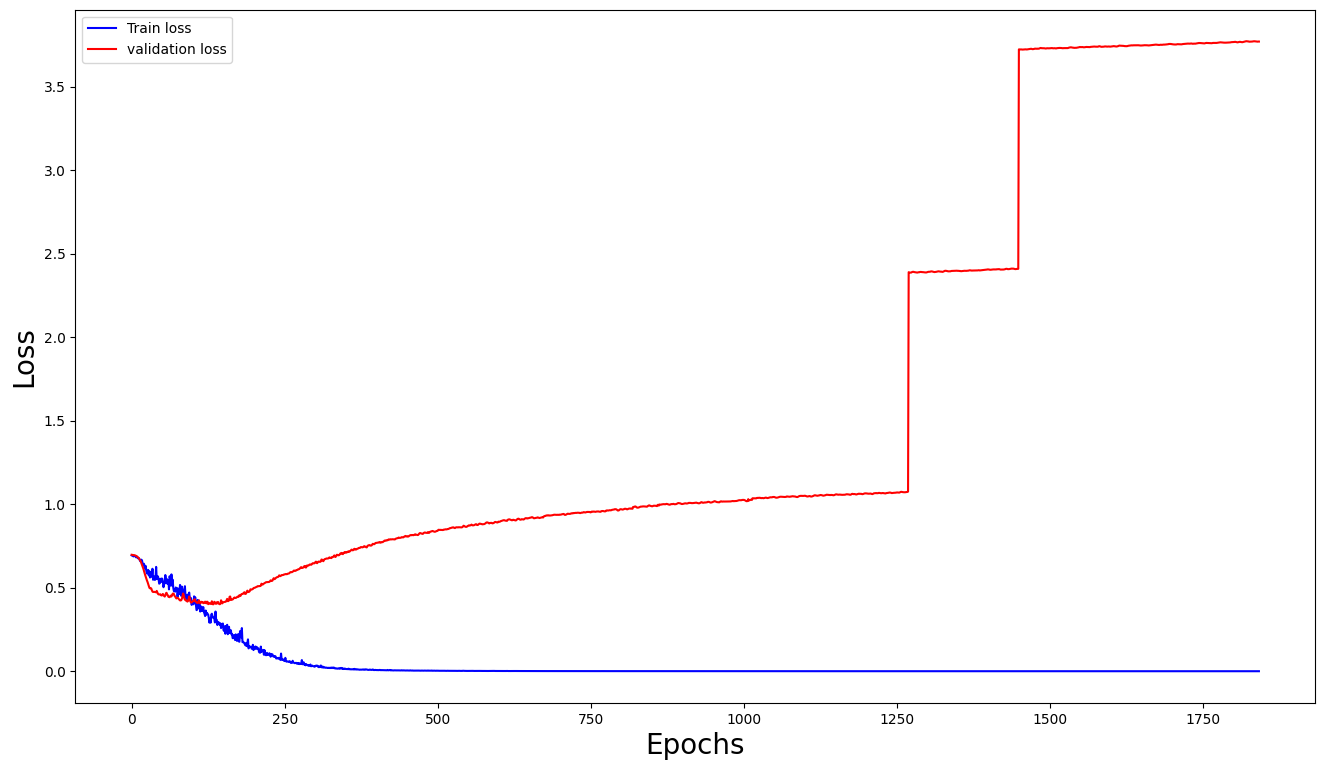

In [81]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label='validation loss')
plt.legend()
plt.grid
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss', fontsize=20)